In [1]:
#below classes we used to interact with any llm model
from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI
from langchain_huggingface import ChatHuggingFace,HuggingFaceEndpoint

#to convert the simple user query to Prompt we are using Chatprompttemplate,prompttemplate
from langchain_core.prompts import PromptTemplate,ChatPromptTemplate

#parser classes to parser 
from langchain_core.output_parsers import StrOutputParser,PydanticOutputParser

#loading the env filter
from dotenv import load_dotenv

from langchain_core.messages import ToolMessage,AIMessage,HumanMessage,SystemMessage,AnyMessage

#below class we used to create nodes of tools and routing the edges based on conditional tools.
from langgraph.prebuilt import ToolNode,tools_condition

from langgraph.graph import MessagesState #below is the predefined class of message that store all the messages in list object mei.

#now adding memory to my workflow.
from langgraph.checkpoint.memory import InMemorySaver #we are adding checkpoint to each superstep to store state or memory value init. 

load_dotenv()

True

In [2]:
#creating an object of chatGroq class
model1 = ChatGroq(
    model="llama-3.1-8b-instant",temperature=0 #temperature is called creative parameter
)

#creating an object openai model class
model2 = ChatOpenAI(
    model="gpt-3.5-turbo",temperature=0
)

#creating an object open source model.
#HuggingFaceEndpoint is a class where we are sending or hitting user query request to get response
llm = HuggingFaceEndpoint(  
        repo_id="meta-llama/Meta-Llama-3-8B-Instruct",  
        task="text-generation",  
        )  
model3 = ChatHuggingFace(llm=llm)

# creating tools that can be used in chatBot

In [3]:
from langchain_core.tools import Tool,tool
#using tavily searching tool.
from langchain_tavily import TavilySearch

search_tool = TavilySearch(
    max_results=2,
    topic="general",)



# Calculator tool
def calculator(first_num: float, second_num: float, operation: str) -> dict:
    try:
        if operation == "add": result = first_num + second_num
        elif operation == "sub": result = first_num - second_num
        elif operation == "mul": result = first_num * second_num
        elif operation == "div": result = first_num / second_num if second_num != 0 else "Division by zero"
        else: return {"error": f"Unsupported operation {operation}"}
        return {"first_num": first_num, "second_num": second_num, "operation": operation, "result": result}
    except Exception as e:
        return {"error": str(e)}

calc_tool = Tool(
    name="Calculator",
    func=calculator,
    description="Perform basic arithmetic: add, sub, mul, div"
)

# Stock price tool
import requests
def get_stock_price(symbol: str) -> dict:
    url = f'https://www.alphavantage.co/query?function=GLOBAL_QUOTE&symbol={symbol}&apikey=1PPNPDOMK62HNKRO'
    return requests.get(url).json()

stock_tool = Tool(
    name="StockPrice",
    func=get_stock_price,
    description="Fetch latest stock price for a given symbol"
)

In [4]:
#binding the tools with llm
lst_tools = [search_tool,stock_tool,calc_tool]
llm_with_tool = model2.bind_tools(lst_tools)
llm_with_tool

RunnableBinding(bound=ChatOpenAI(client=<openai.resources.chat.completions.completions.Completions object at 0x000002891A7A5300>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x000002891A7A6170>, root_client=<openai.OpenAI object at 0x000002891A7A5840>, root_async_client=<openai.AsyncOpenAI object at 0x000002891ABBFCD0>, temperature=0.0, model_kwargs={}, openai_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'tavily_search', 'description': 'A search engine optimized for comprehensive, accurate, and trusted results. Useful for when you need to answer questions about current events. It not only retrieves URLs and snippets, but offers advanced search depths, domain management, time range filters, and image search, this tool delivers real-time, accurate, and citation-backed results.Input should be a search query.', 'parameters': {'properties': {'query': {'description': 'Search query to look up', 'type':

# building the workflow

In [5]:
#creating an object of checkpointer Inmemory class
checkpointer = InMemorySaver()

#here we are not defining stateschema class because using predefined classes MessagesState
from langgraph.graph import StateGraph,END,START
#creating an object of stateGraph class.
graph = StateGraph(state_schema=MessagesState)
graph

In [6]:
#defining the function for chatnode that performing actions
def chat_node(state:MessagesState) ->MessagesState:
    #fetching the latest message from state class.
    latest_msg = state['messages']
    
    #passing this messgae to tool bind models.
    response = llm_with_tool.invoke(input=latest_msg)  
    #when the latest message come to this model parallel tool will call get append tool msg init.
    
    #now updating the state with ai response.
    return {
        'messages': [response]
    }

In [7]:
#creating user defined fuction for tool_node.
tool_node = ToolNode(tools=lst_tools)

In [8]:
#now adding nodes to graph.
graph.add_node(node="chat_node",action=chat_node)
graph.add_node(node="tools",action=tool_node)

### sending back Tool Message to get refined result show in output

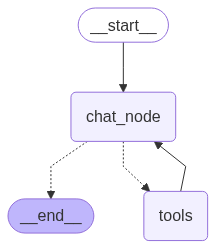

In [9]:
#now adding edges to graph.
graph.add_edge(START,"chat_node")
graph.add_conditional_edges("chat_node",tools_condition) 
#tools_condition check wheather tool msg present from reposne coming from chat_node if yes redirect to tool_node or else will end.
graph.add_edge('tools',"chat_node")
graph.compile()

In [10]:
#compiling the workflow passing the initial state to my workflow.
worklfow = graph.compile(checkpointer=checkpointer)

#defining the initial state message and passing to my worklfow.
message = [HumanMessage(content="who is the president of india?")]

#now invoking the workflow to start execution
config1 = {'configurable' : {'thread_id':'1'}}

response = worklfow.invoke({'messages':message},config=config1)
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

who is the president of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_LkrZRQmeLbodzplIXgZ5TXKM)
 Call ID: call_LkrZRQmeLbodzplIXgZ5TXKM
  Args:
    query: current president of India
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "current president of India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/President_of_India", "title": "President of India - Wikipedia", "content": "Droupadi Murmu is the 15th and current president, having taken office on 25 July 2022. President of the Republic of India. Bhārata kē Rāṣṭrapati. f · Flag of", "score": 0.9152729, "raw_content": null}, {"url": "https://www.jagranjosh.com/general-knowledge/list-of-all-presidents-of-india-from1947-to-2017-wit

In [11]:
# question number:2
#compiling the workflow passing the initial state to my workflow.
worklfow = graph.compile(checkpointer=checkpointer)

#defining the initial state message and passing to my worklfow.
message = [HumanMessage(content="what is 2 multiply by 4 then divide by 2 what is the final answer?")]

#now invoking the workflow to start execution
config1 = {'configurable' : {'thread_id':'1'}}

response = worklfow.invoke({'messages':message},config=config1)
for msg in response['messages']:
    msg.pretty_print()

================================ Human Message =================================

who is the president of india?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_LkrZRQmeLbodzplIXgZ5TXKM)
 Call ID: call_LkrZRQmeLbodzplIXgZ5TXKM
  Args:
    query: current president of India
    search_depth: basic
================================= Tool Message =================================
Name: tavily_search

{"query": "current president of India", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://en.wikipedia.org/wiki/President_of_India", "title": "President of India - Wikipedia", "content": "Droupadi Murmu is the 15th and current president, having taken office on 25 July 2022. President of the Republic of India. Bhārata kē Rāṣṭrapati. f · Flag of", "score": 0.9152729, "raw_content": null}, {"url": "https://www.jagranjosh.com/general-knowledge/list-of-all-presidents-of-india-from1947-to-2017-wit

### We use the built-in ToolNode and simply pass a list of our tools to initialize it nodes of tools in worklfow.

### We use the built-in tools_condition as our conditional edge.

# if i want to show all the checkpointer step ka memory state value achieve by using

In [12]:
list(worklfow.get_state(config=config1))

[{'messages': [HumanMessage(content='who is the president of india?', additional_kwargs={}, response_metadata={}, id='f75100f9-e4fa-4695-9212-35c79f57fb85'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LkrZRQmeLbodzplIXgZ5TXKM', 'function': {'arguments': '{"query":"current president of India","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1407, 'total_tokens': 1431, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CGlsR6IogyAIaH0E10jPOmQ7PilY4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e08817e8-eaf5-4e55-99d1-a08d7e4c12e9-0', tool_calls=[{'name': 'tavily_search'

In [13]:
#below will show each checkpointer whatever they have store in memory state value mei.
list(worklfow.get_state_history(config=config1))

[StateSnapshot(values={'messages': [HumanMessage(content='who is the president of india?', additional_kwargs={}, response_metadata={}, id='f75100f9-e4fa-4695-9212-35c79f57fb85'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_LkrZRQmeLbodzplIXgZ5TXKM', 'function': {'arguments': '{"query":"current president of India","search_depth":"basic"}', 'name': 'tavily_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1407, 'total_tokens': 1431, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-CGlsR6IogyAIaH0E10jPOmQ7PilY4', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--e08817e8-eaf5-4e55-99d1-a08d7e4c12e9-0', tool_calls=[{'name